# Телеком

## Общие данные по проекту

**Описание проекта**

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг:

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

 **Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020


**Описание полей данных**

-`BeginDate` – дата начала пользования услугами,

-`EndDate` – дата окончания пользования услугами,

-`Type` – тип договора: ежемесячный, годовой и т.д,

-`PaperlessBilling`  – факт выставления счёта на электронную почту,

-`PaymentMethod` – способ оплаты,

-`MonthlyCharges` – ежемесячные траты на услуги,

-`TotalCharges` – всего потрачено денег на услуги,

-`Dependents` – наличие иждивенцев,

-`Senior Citizen` – наличие пенсионного статуса по возрасту,

-`Partner` – наличие супруга(и),

-`MultipleLines` – наличие возможности ведения параллельных линий во время звонка.

 -`EndDate` - целевой признак

**Информация по задаче**

- Для оценки и обучения используется метрика ROC-AUC. Дополнительно можно смотреть - F1.


- Критерии оценки:
Минимальный порог для успешной сдачи AUC-ROC >= 0.85


- При делении на выборки соотношение тренировочной к тестовой = 3/1.

## План работы

1. Провести первичный разведывательный анализ данных
2. Предобработать данные каждого столбца до объединения
3. Объединить и провести исследовательский анализ данных
4. Проверить на дисбаланс классов
4. Разбить датасет на таргеты и фичи
5. Подготовить пайплайны и кодировщики
6. Создать словарь гиперпараметров для моделей и ансамблей
7. С помощью кроссвалидации RandomisedSearchCV найти лучшую модель по метрике ROC-AUC
8. Вывести лучшие гиперпараметры
9. Проверить качество лучшей модели на тесте
10. Построить графики важности фичей и матрицы ошибок
11. Выводы

**Цель проекта:**
Определить, какие факторы способствуют уходу клиента (какие клиенты планируют уходить), и на их основании создать модель прогнозирования оттока клиентов

## Разведывательный анализ данных

### Импортируем нужные библиотеки и настройки

In [1]:
!pip install phik

In [2]:
!pip install skimpy

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy import stats as st
from scipy.stats import kstest
from datetime import datetime as dt
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
import datetime
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:,.2f}".format)

import warnings
warnings.filterwarnings('ignore')

from phik import phik_matrix
from phik import resources, report
from skimpy import skim
from skimpy import clean_columns
from sklearn.metrics import confusion_matrix

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler 
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score

In [6]:
random_state = 130323

### Считаем данные 

Создадим переменную для корневого пути и импортируем данные

In [7]:
way = 'C:/zzz/final_provider'

In [8]:
try:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
except FileNotFoundError:
    contract = pd.read_csv(way + '/contract.csv')
try:
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
except FileNotFoundError:
    internet = pd.read_csv(way + '/internet.csv')
try:
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
except FileNotFoundError:
    personal = pd.read_csv(way + '/personal.csv')
try:
    phone = pd.read_csv('/datasets/final_provider/phone.csv')
except FileNotFoundError:
    phone = pd.read_csv(way + '/phone.csv')    

Напишем функцию для получения полной инфы по каждому датафрейму

In [9]:
def information(df: 'DataFrame', name: 'str') -> None:
    '''Функция напечатает информацию по датасету: первые три строки,
    название столбцов, кол-во строк и их тип, кол-во пропущенных значений,
    разброс, среднее, медиану, макс и мин значения, полные дубликаты и 
    уникальные значения'''
    print('*'*30,name,'*'*30)
    print()
    display(df.head(3))
    print('-'*25,'INFO','-'*25)
    print()
    print(df.info())
    print()
    print('-'*10,'NAN','-'*10)
    print()
    print(df.isna().sum())
    print()
    print('-'*5,'DESCRIBE','-'*5)
    print(df.describe())
    print()
    print('-'*5,'DUPLICATED','-'*5)
    print(df.duplicated().sum())
    print()
    print('-'*25,'UNIQUE VALUES','-'*25)
    for column in df.columns:
        print(column)
        print(df[column].unique())
        print('+'*25)

### contract

In [10]:
information(contract, 'CONTRACT')

****************************** CONTRACT ******************************



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


------------------------- INFO -------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

---------- NAN ----------

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

----- DESCRIBE -----
       MonthlyCharges
count        7,043.00
mean            64.76
st

В этом файле информация о договоре

Колонки:

`customerID` - id пользователя

`BeginDate` – дата начала пользования услугами

`EndDate` – дата окончания пользования услугами

`Type` – тип договора: ежемесячный, годовой и т.д

`PaperlessBilling` – факт выставления счёта на электронную почту

`PaymentMethod` – способ оплаты

`MonthlyCharges` – ежемесячные траты на услуги

`TotalCharges` – всего потрачено денег на услуги

Пропусков в данных не обнаружено, только столбец MonthlyCharges имеет тип численный 

Для ряда столбцов нужно изменить тип данных

Для столбца MonthlyCharges среднее равно 64.7

Попробуем сменить тип данных столбце total_charges

In [13]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract = contract.dropna().reset_index(drop=True)

In [14]:
# Проверка столбца ну пропуски
contract['TotalCharges'].isna().sum()

0

In [15]:
# создадим списки для объекто-категориальных и числовых значений
cat, numeric = [], []
[cat.append(col) if contract[col].dtypes == 'object' else numeric.append(col) for col in contract.columns];

**Построим так же графики распределения для категориальных и числовых столбцов**

In [16]:
# Функция для построения графиков объекто-категориальных столбцов, 
# а так же столбцов с датой в формате 'object'
def cat_bar(df: 'DataFrame', axes: 'int', col: 'str') -> None:
    '''Функция построит барплот для категориального
    столбца датафрейма'''
    plt.subplot(axes)
    plt.bar(df[col].unique(),df[col].value_counts())
    plt.grid()
    plt.xticks(rotation=90)
    plt.title(col)
    plt.ylabel('Количество')

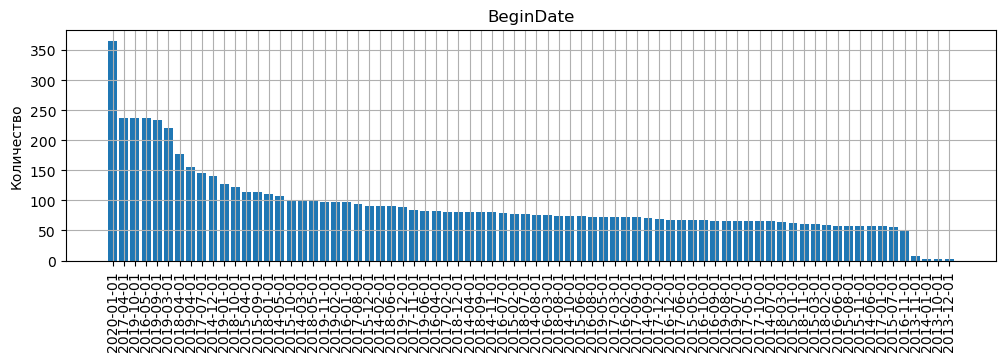

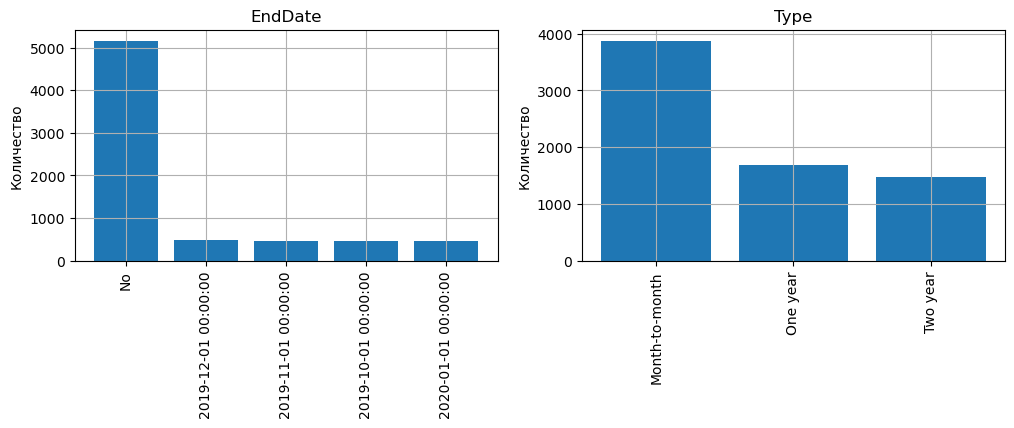

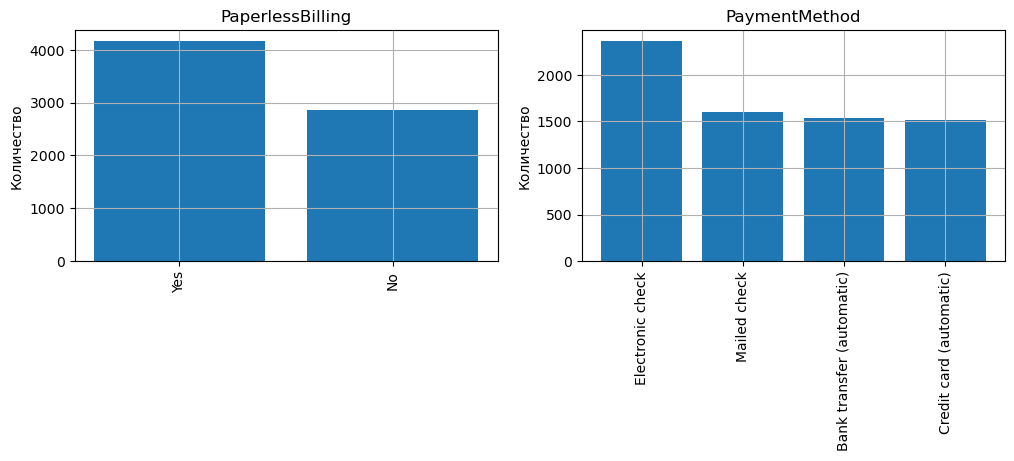

In [17]:
# объекто-категориальные столбцы
plt.figure(figsize=(12, 3))
cat_bar(contract, 111,cat[1])
plt.figure(figsize=(12, 3))
cat_bar(contract, 121,cat[2])
cat_bar(contract, 122,cat[3])
plt.figure(figsize=(12, 3))
cat_bar(contract, 121,cat[4])
cat_bar(contract, 122,cat[5])

Из всех графиков самым интересным для нас кажется график с датой прекращения обслуживания. Мы имеем подряд 3 месяца с 01.10.2019 до 01.01.2020 когда люди у нас уходили. На этот срез посмотрим в разделе анализа данных и выясним причины.

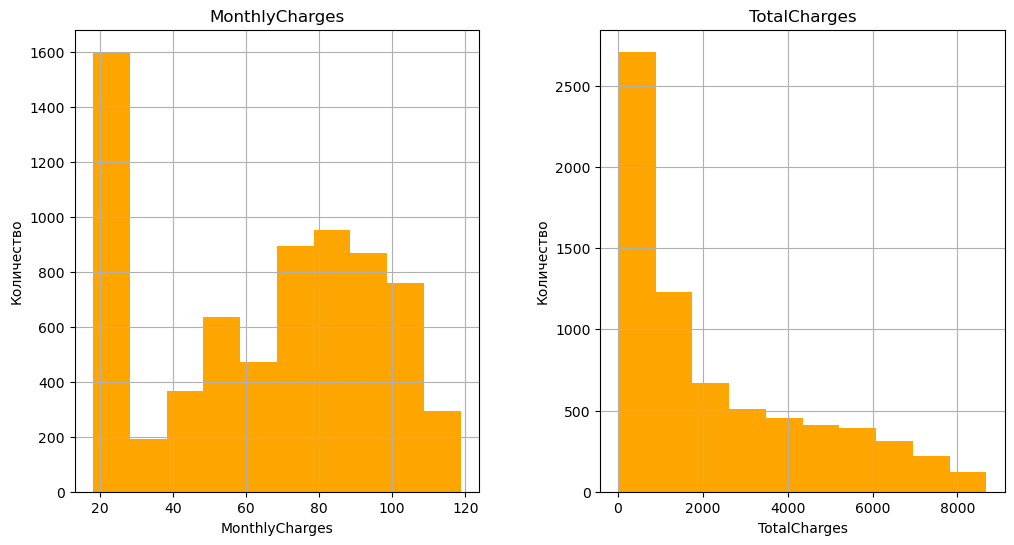

In [18]:
# числовые столбцы
ax = contract[numeric].hist(bins=10, figsize=(12, 6), color='orange', grid = True, xlabelsize=10)
ax[0, 0].set_xlabel(numeric[0])
ax[0, 0].set_ylabel('Количество')
ax[0, 1].set_xlabel(numeric[1])
ax[0, 1].set_ylabel('Количество')

plt.show();

Из графиков можно сделать вывод, что в больше всего людей в месяц тратили 20 у.е. и 80-90 у.е. (два пиковых значения).
В столбце всего потрачено больше всего людей не потратило ни пени. Является ли это выбросом сделаем вывод позже (возможно это имелось в виду дополнительные услуги).

Теперь заменим в столбце с конечной датой значения 'No' на дату выгрузки '2020-02-01'. Это логично, так как на этот момент человек не разорвал договор и в столбце нам нужна дата для обработки и последующих вычислений. Следом приведём дату к соответствующему типу

In [19]:
contract.loc[contract['EndDate'] == 'No', 'EndDate'] = '2020-02-01'

In [20]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d %H:%M:%S')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d %H:%M:%S')

### personal

In [22]:
information(personal, 'PERSONAL')

****************************** PERSONAL ******************************



,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


------------------------- INFO -------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

---------- NAN ----------

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

----- DESCRIBE -----
       SeniorCitizen
count       7,043.00
mean            0.16
std             0.37
min             0.00
25%             0.00
50%             0.00
75%             0.00
max             1.00

----- DUPLICATED -----
0

------------------------- UNIQUE VALUES -------------------------
customerID
['7590-VHVEG' '5575-GNVDE' 

В этом файле персональные данные клиента

Колонки:

`customerID` - id клиента

`gender` - пол

`SeniorCitizen` - наличие пенсионного статуса по возрасту

`Partner` - наличие супруга/ги

`Dependents` - наличие иждивенцев


Пропусков в данных не обнаружено, только столбец SeniorCitizen - типа int, 1 и 0 принимает в качестве значений

**Построим так же графики распределения для категориальных и числового столбца**

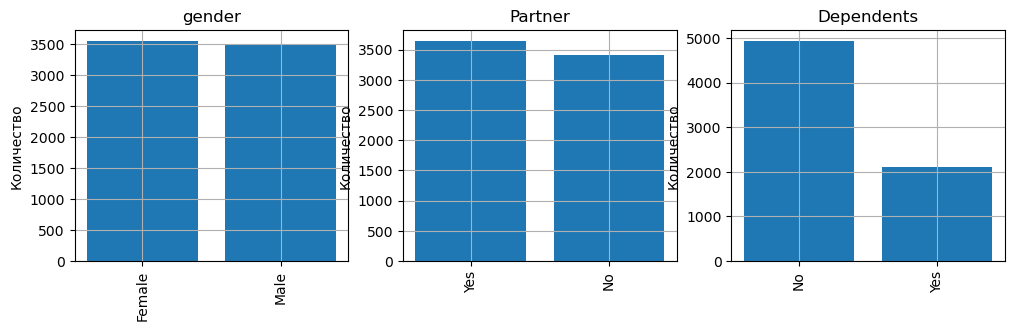

In [23]:
# категориальные столбцы
plt.figure(figsize=(12, 3))
cat_bar(personal, 131,'gender')
cat_bar(personal, 132,'Partner')
cat_bar(personal, 133,'Dependents')

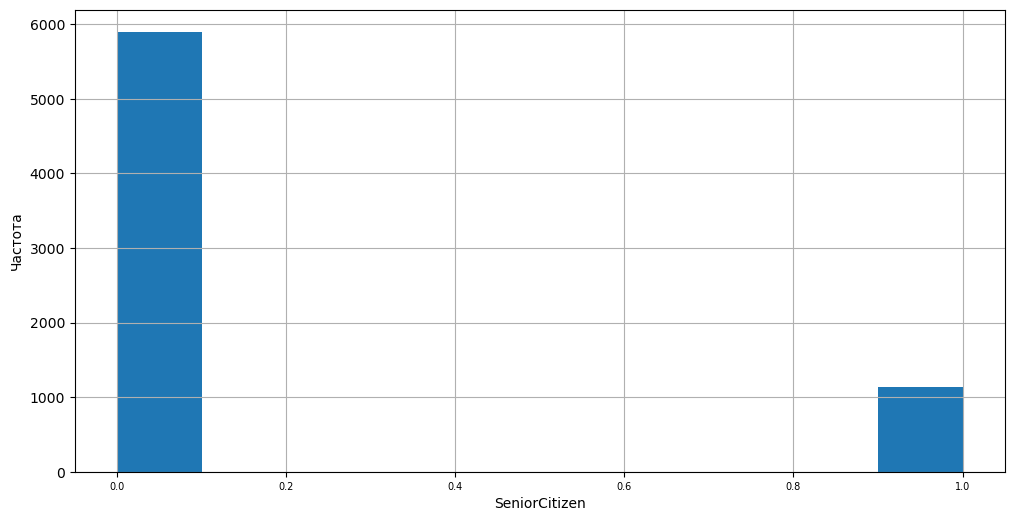

In [24]:
# числовые столбцы
personal['SeniorCitizen'].hist(bins=10, figsize=(12, 6), grid = True, xlabelsize=7)
plt.xlabel('SeniorCitizen')
plt.ylabel('Частота')

plt.show()

Посмотрели на распределение графиков. Подчеркнуть что-то важное не удалось

### internet

In [25]:
information(internet, 'INTERNET')

****************************** INTERNET ******************************



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


------------------------- INFO -------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

---------- NAN ----------

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

----- DESCRIBE -----
        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517      

В этом файле информация об интернет-услугах

Колонки:

`customerID` - id пользователя

`InternetService` - интернет-услуги

`OnlineSecurity` - блокировка небезопасных сайтов 

`OnlineBackup` - блачное хранилище файлов для резервного копирования данных

`DeviceProtection` - антивирус

`TechSupport` - выделенная линия технической поддержки

`StreamingTV` - стриминговое телевидение

`StreamingMovies` - каталог фильмов




Пропусков нет, все данные типа object

**Построим графики распределения для категориальных столбцов**

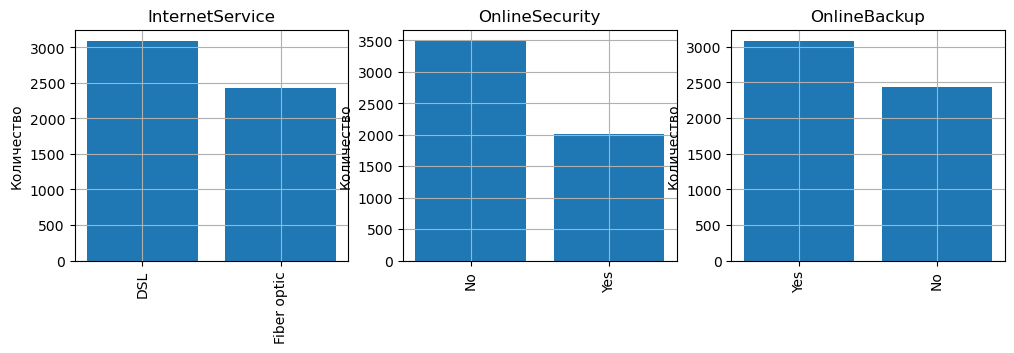

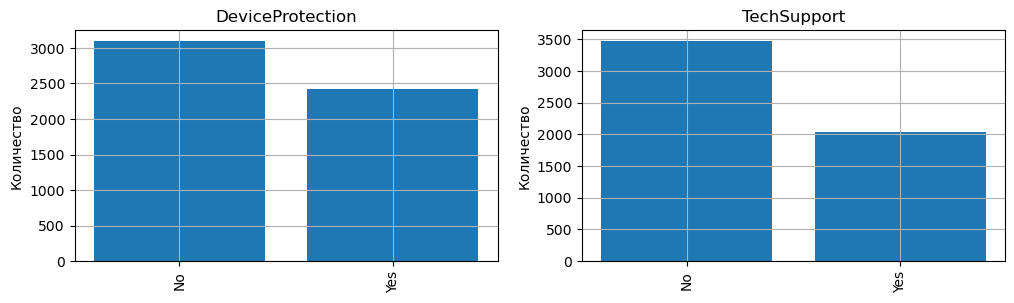

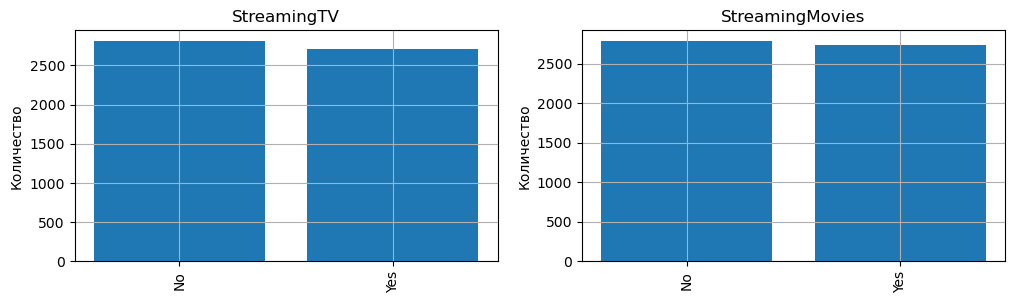

In [26]:
# категориальные столбцы
plt.figure(figsize=(12, 3))
cat_bar(internet, 131,'InternetService')
cat_bar(internet, 132,'OnlineSecurity')
cat_bar(internet, 133,'OnlineBackup')
plt.figure(figsize=(12, 3))
cat_bar(internet, 121,'DeviceProtection')
cat_bar(internet, 122,'TechSupport')
plt.figure(figsize=(12, 3))
cat_bar(internet, 121,'StreamingTV')
cat_bar(internet, 122,'StreamingMovies')

На первый взгяд ничего интересного)

### phone

In [27]:
information(phone, 'PHONE')

****************************** PHONE ******************************



,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


------------------------- INFO -------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

---------- NAN ----------

customerID       0
MultipleLines    0
dtype: int64

----- DESCRIBE -----
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390

----- DUPLICATED -----
0

------------------------- UNIQUE VALUES -------------------------
customerID
['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
+++++++++++++++++++++++++
MultipleLines
['No' 'Yes']
+++++++++++++++++++++++++


В этом файле информация об услугах телефонии

Колонки: 

`customerID` - id пользователя

`MultipleLines` – наличие возможности ведения параллельных линий во время звонка

Пропусков нет, данные типа object

**Построим график распределения единственного столбца**

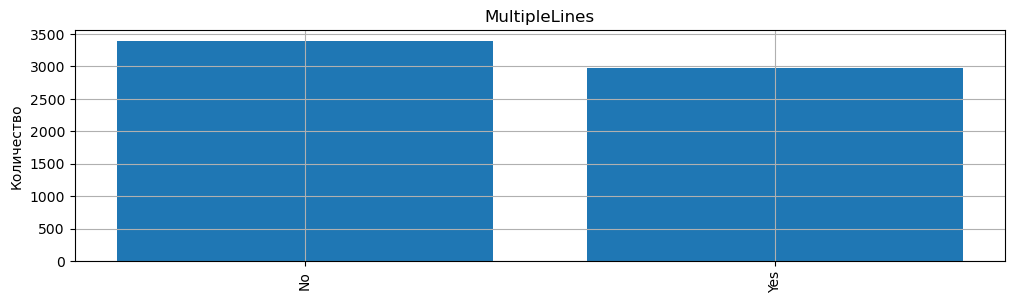

In [28]:
# категориальный столбец
plt.figure(figsize=(12, 3))
cat_bar(phone, 111,'MultipleLines')

Ничего важного не наблюдается

### Общая предобработка

Все столбцы будет необходимо привести к змеиному регистру. Так же в датасетах интернета и телефона у нас строк меньше чем в первых двух, что говорит нам о том, что клиенты не подключили те или иные услуги (при объединении придётся ставить заглушки)

Приведем к змеиному регистру

In [29]:
contract = clean_columns(contract)
personal = clean_columns(personal)
internet = clean_columns(internet)
phone = clean_columns(phone)

8 column names have been cleaned

4 column names have been cleaned

8 column names have been cleaned

2 column names have been cleaned

### Минивывод:

Предварительный анализ показал, что нам надо обратить внимание на срез по времени, когда был замечен отток клиентов. Скорее всего исследовательский анализ данных будет сосредоточен именно на этом временном промежутке

## Анализ данных и подготовка признаков

### Объединение столбцов

In [30]:
df = pd.merge(contract, personal, on='customer_id', how='outer')
df = pd.merge(df, internet, on='customer_id', how='outer')
df = pd.merge(df, phone, on='customer_id', how='outer')

In [31]:
information(df, 'DF')

****************************** DF ******************************



,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,"1,889.50",Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No


------------------------- INFO -------------------------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   gender             7043 non-null   object        
 9   senior_citizen     7043 non-null   int64         
 10  partner            7043 non-null   object        
 11  dependents         7043 non-null   object        
 12  internet_service   5517 non-null   object        
 13  onlin

У нас снова вылезли Nan, которые уже удаляли за счёт присоединения столбцов через 'outer'. Удалим

In [32]:
df = df.loc[df['begin_date'].isna()==False]

Заменим пропущенные значения для людей, которые не пользуются услугами интернета или многими линиями телефона.

In [33]:
df = df.fillna('No')

In [34]:
# проверим на пропуски
df.isna().sum()

customer_id          0
begin_date           0
end_date             0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
multiple_lines       0
dtype: int64

Добавим столбец с кол-вом месяцев от начала регистрации и до конца (либо до ухода)

In [35]:
df['day'] = (df['end_date'] - df['begin_date']) // np.timedelta64(1, 'D') 

Добавим целевой столбец, где 0 - не ушёл, 1 - ушёл

In [36]:
df['churn'] = 0
df.loc[df['end_date']!= '2020-02-01', 'churn'] = 1

In [37]:
# для ушедших пользователей
df_out = df.loc[df['churn'] == 1]
df_out.describe()

,monthly_charges,total_charges,senior_citizen,day,churn
count,"1,869.00","1,869.00","1,869.00","1,869.00","1,869.00"
mean,74.44,"1,531.80",0.25,547.35,1.00
std,24.67,"1,890.82",0.44,594.39,0.00
min,18.85,18.85,0.00,30.00,1.00
25%,56.15,134.50,0.00,61.00,1.00
50%,79.65,703.55,0.00,304.00,1.00
75%,94.20,"2,331.30",1.00,883.00,1.00
max,118.35,"8,684.80",1.00,"2,191.00",1.00


Посмотрим сколько времени требовалось клиенту для принятия решения

### Построим график, показывающий распределение времени

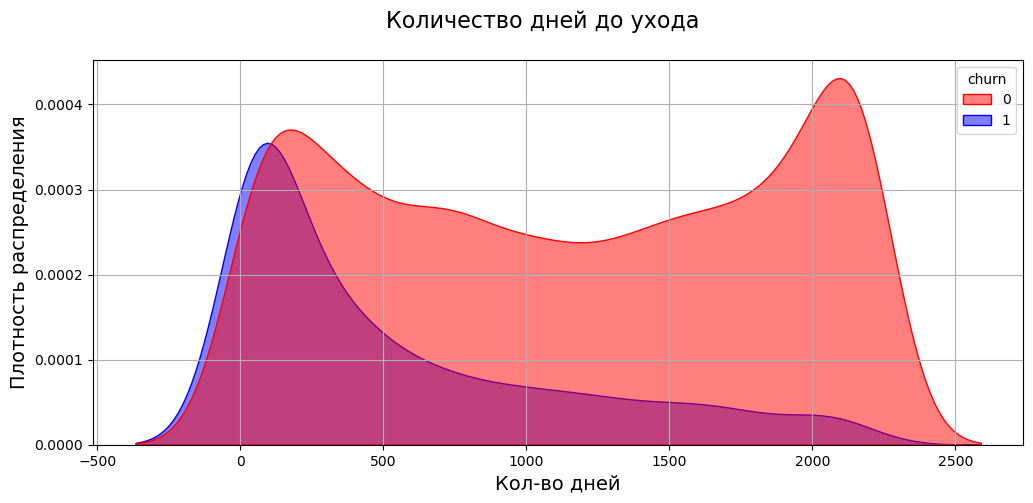

In [38]:
fig, ax = plt.subplots(figsize=(12,5))
fig.suptitle('Количество дней до ухода', fontsize=16)
kdeplot_t = sns.kdeplot(df['day'], palette=['r', 'b'], 
                        alpha=.5, shade=True, hue=df['churn'])
plt.grid()
kdeplot_t.set_xlabel("Кол-во дней", fontsize=14)
kdeplot_t.set_ylabel("Плотность распределения", fontsize=14)
plt.show()

### Построим график длительности контракта

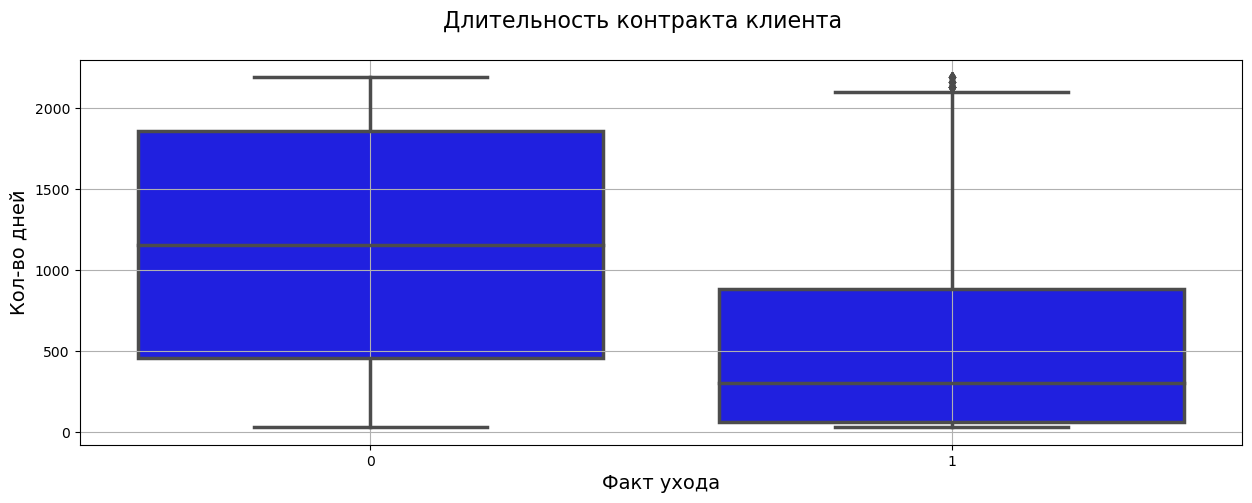

In [39]:
fig, axs = plt.subplots(figsize=(15, 5))
    
fig.suptitle('Длительность контракта клиента', fontsize=16)

sns.boxplot(x='churn', y='day', data=df, color='blue', linewidth=2.5)
plt.grid()
plt.xlabel('Факт ухода', fontsize=14)
plt.ylabel('Кол-во дней', fontsize=14)
plt.show()

Чтобы не делать преждевременных выводов про время сотрудничества посмотрим, какие контракты у нас преобладают

In [40]:
df_out.groupby('type')['type'].count()

type
Month-to-month    1655
One year           166
Two year            48
Name: type, dtype: int64

По графикам и дискрайбу мы видим, что большинство людей принимало решение довольно быстро и чем дольше остаётся человек в компании тем меньше вероятность его ухода (проверили, что у нас в основном контракты помесячные, контрактов на год и на два намного меньше). Попробуем выяснить, что стало причиной принятия такого решения и обратимся к столбцам с оплатами.

### Построим графики по ежемесячному платежу и по общему платежу

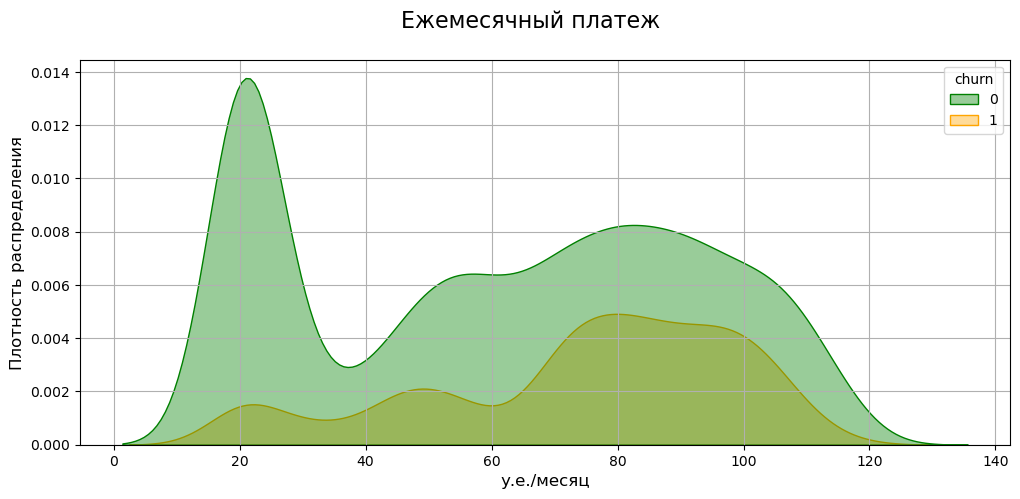

In [41]:
fig, ax = plt.subplots(figsize=(12,5))
fig.suptitle('Ежемесячный платеж', fontsize=16)
kdeplot_t = sns.kdeplot(df['monthly_charges'], palette=['green', 'orange'], 
                        alpha=.4, shade=True, label='22', hue=df['churn'])
plt.grid()
kdeplot_t.set_xlabel("у.е./месяц", fontsize=12)
kdeplot_t.set_ylabel("Плотность распределения", fontsize=12)
plt.show()

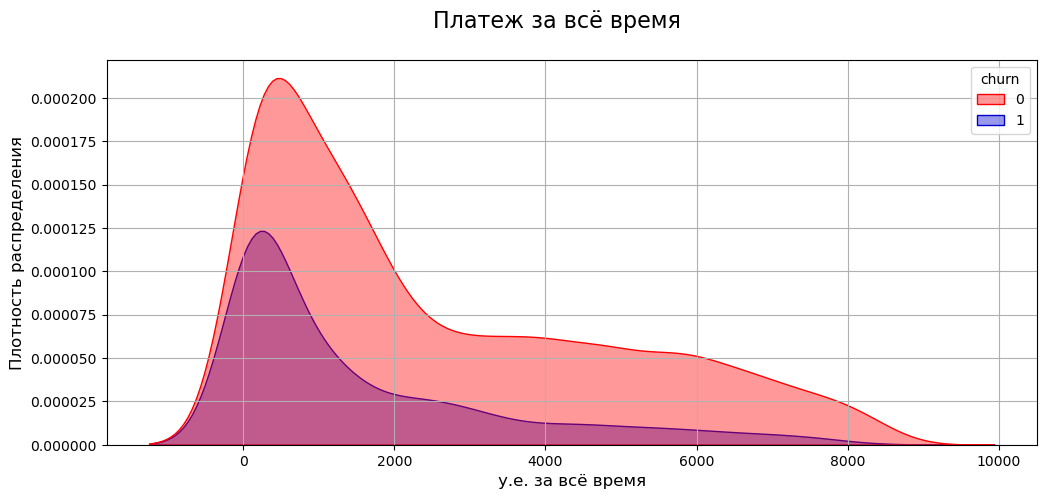

In [42]:
fig, ax = plt.subplots(figsize=(12,5))
fig.suptitle('Платеж за всё время', fontsize=16)
kdeplot_t = sns.kdeplot(df['total_charges'], palette=['red', 'mediumblue'], 
                        alpha=.4, shade=True, label='22', hue=df['churn'])
plt.grid()
kdeplot_t.set_xlabel("у.е. за всё время", fontsize=12)
kdeplot_t.set_ylabel("Плотность распределения", fontsize=12)
plt.show()

In [43]:
df.groupby('churn')['total_charges', 'monthly_charges', 'day'].median()

,total_charges,monthly_charges,day
churn,,,
0,"1,683.60",64.45,"1,157.00"
1,703.55,79.65,304.00


Если посмотреть на общий платёж, то те, кто остались вроде бы платят больше. Но ведь они и в среднем дольше находятся в компании, поэтому это логично. А вот ежемесячный платёж заметно больше в пиковых значениях у тех, кто ушёл.

### Проверим наши выводы и выдвинем гипотезу

H0: ежемесячный платёж у тех клиентов, кто ушёл равен ежемесячному платежу у тех, кто остался
    
    
H1: ежемесячные платёж у тех клиентов, кто ушёл и у тех, кто остался - различны

In [44]:
alpha = 0.05

monthly_charges_0 = df.loc[df['churn'] == 0]['monthly_charges']
monthly_charges_1 = df.loc[df['churn'] == 1]['monthly_charges']

results = st.ttest_ind(monthly_charges_0, monthly_charges_1, equal_var=False)


print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.6573571445160277e-72
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута. Принимаем гипотезу H1.

### Построим графики распределения категориальных столбцов

In [45]:
# Напишем функцию
def categorial_plot(x: 'str', name: 'str', xlabel: 'str',
                   ylabel='кол-во пользователей', data=df, hue='churn', rot=30) -> None:
    """Функция выведет на экран график распределения для 
    категориального столбца, разделенный по группам ушёл/не ушёл"""
    sns.countplot(x=x, data=df, hue=hue)
    plt.title(name)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rot)
    plt.show()

In [46]:
# создадим список категориальных столбцов
columns = ['payment_method', 'type', 'paperless_billing', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines']

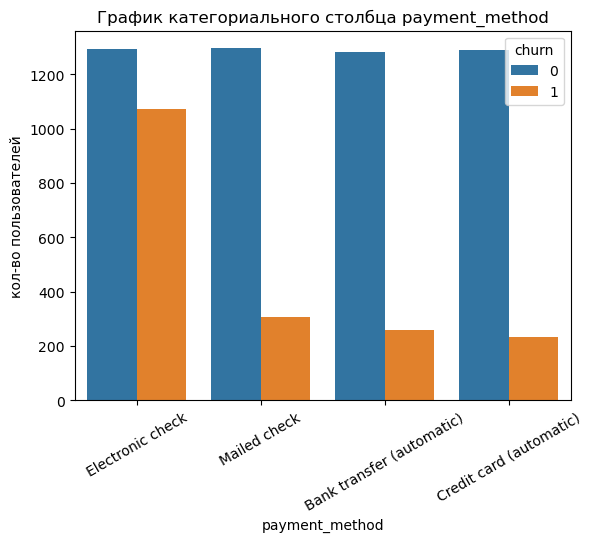

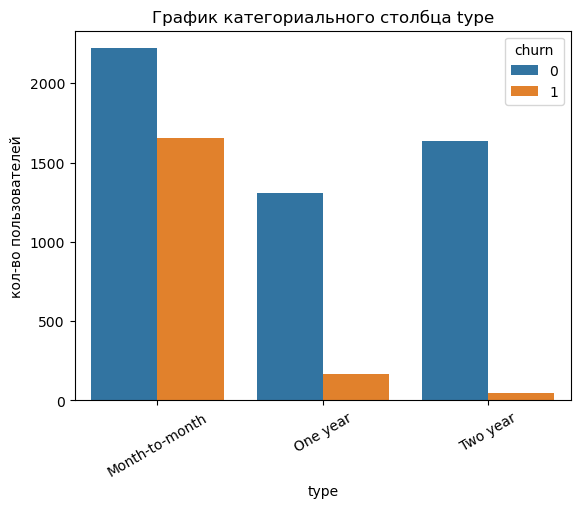

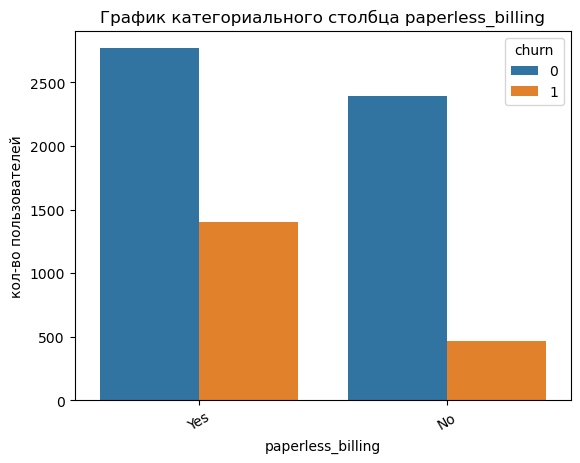

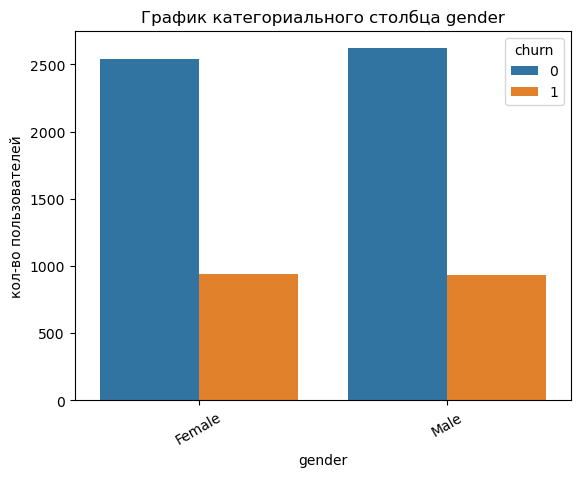

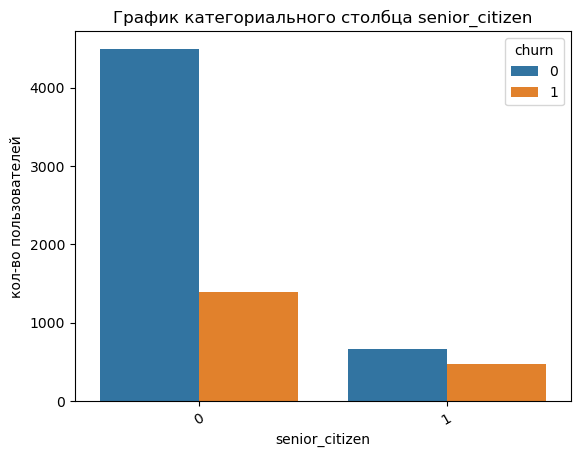

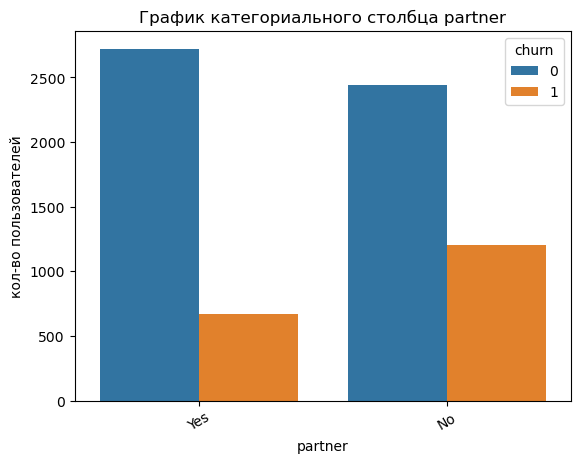

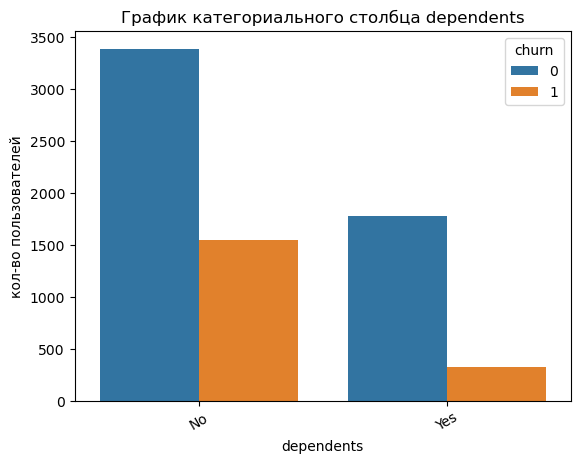

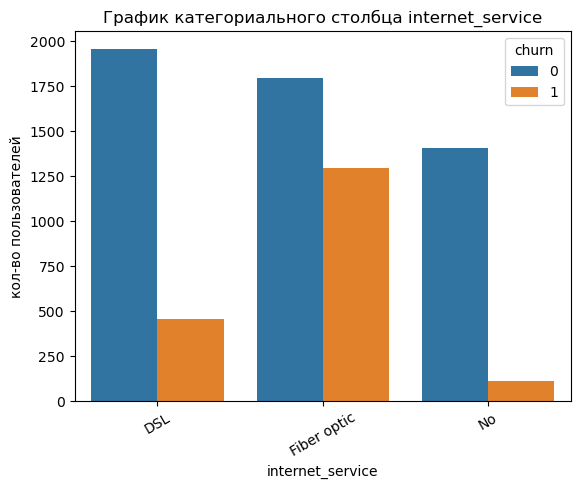

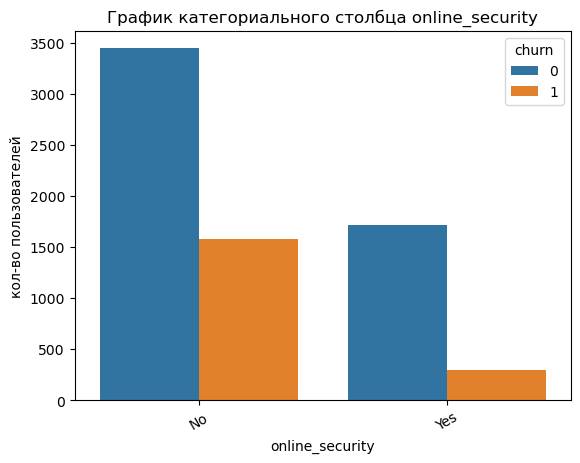

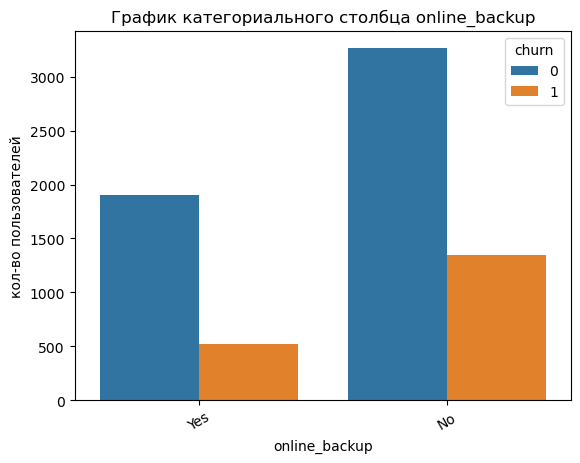

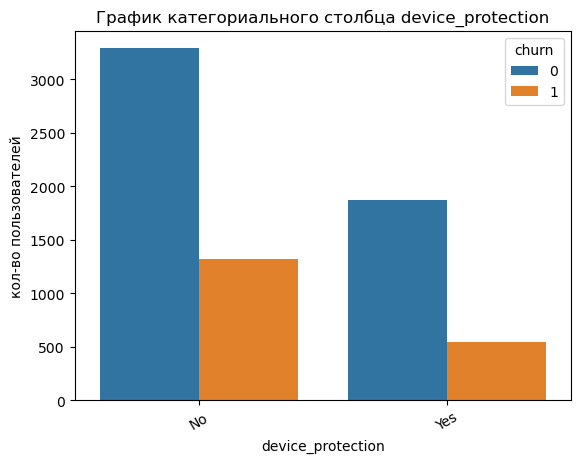

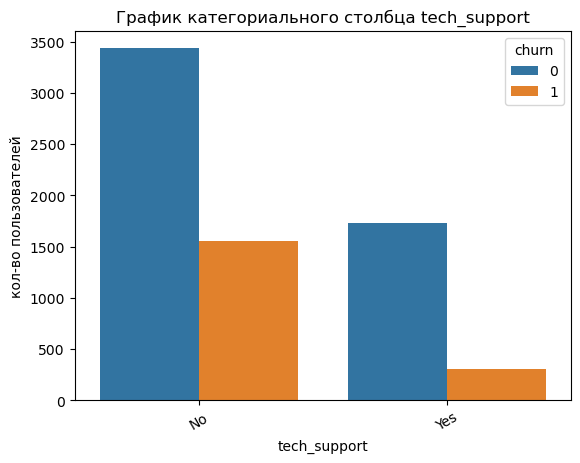

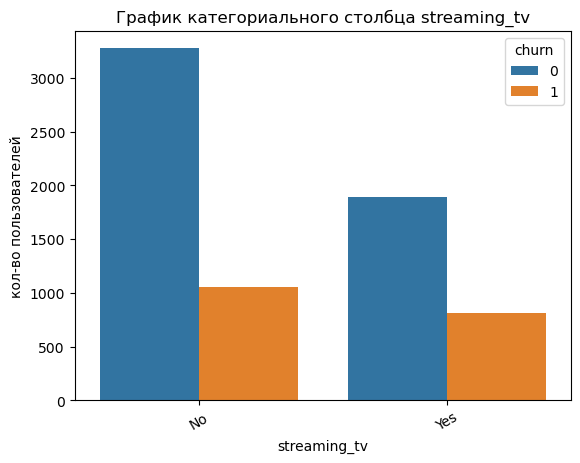

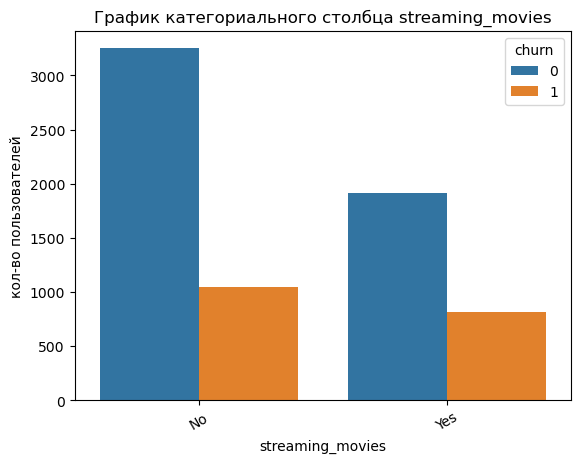

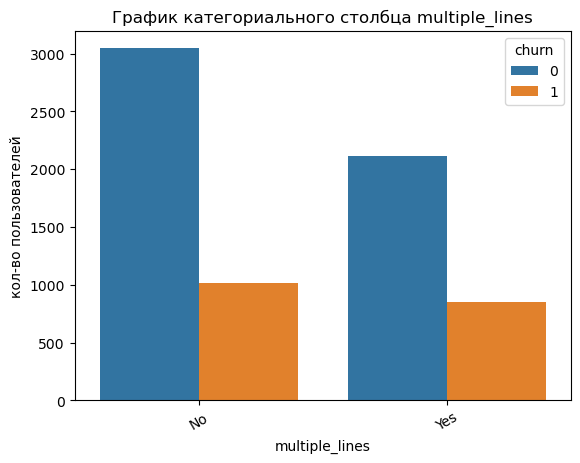

In [47]:
[categorial_plot(col, f'График категориального столбца {col}', col) for col in columns];

**Исследовав категориальные столбцы следует отметить, что отток больше всего замечен:**
- в методе оплаты "электронный чек" (не автоматический тип оплаты)
- в типе оплаты "каждый месяц"
- в столбце в безбумажным выставлением счетов
- незначительно отток больше у людей непенсионного возраста и без партнёра 
- в категории людей без наличия иждивенцев
- у интернет провайдера "Fiber optic"
- в категории без наличия онлайн защиты
- в категории без онлайн резервного копирования
- в категории без защиты устройства
- в категории без технической поддержки

### Перед работой с корреляциями поработаем с типами категориальных столбцов

In [48]:
# у нас есть два столбца типа "int", но по своей природе категориальные. Исправим это.
df[['senior_citizen', 'churn']] = df[['senior_citizen', 'churn']].astype('category')

In [49]:
# список с категориальными столбцами без айди клиента, но с целевым признаком
cat = [col for col in df.columns if (df[col].dtypes == 'object') or
      (df[col].dtypes == 'category')]
cat.pop(0);

In [50]:
# сделаем категориальные столбцы категориальными
df[cat] = df[cat].astype('category')

### Посмотрим на корреляции между признаками

**тепловая карта числовых признаков**

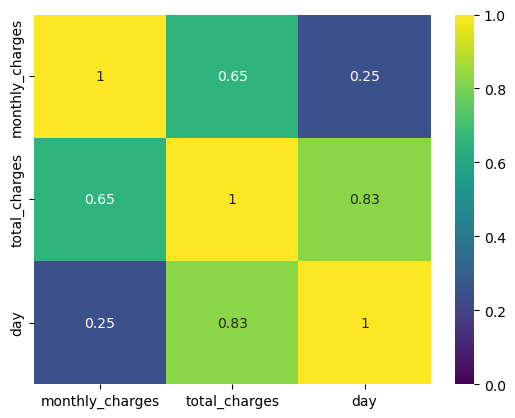

In [51]:
sns.heatmap(df.corr(), cmap='viridis', annot=True, vmin=0);

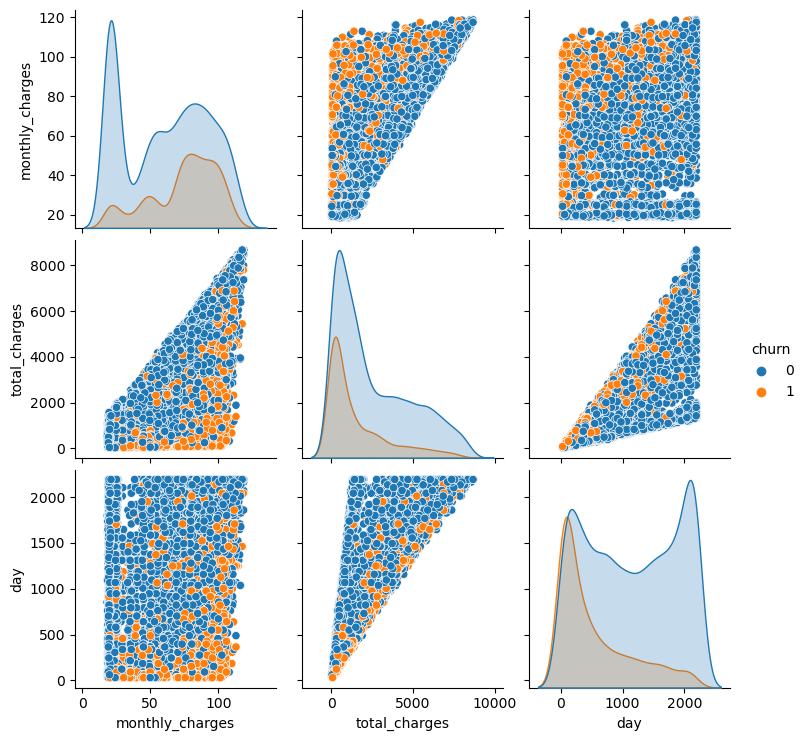

In [52]:
# построим паирплот дополнительно для проверки корреляций

sns.pairplot(df, hue='churn');

Есть высокая корреляция между столбцами "month" и "total_charges". "total_charges" будем убирать

**Построим тепловую карту для категориальных столбцов**

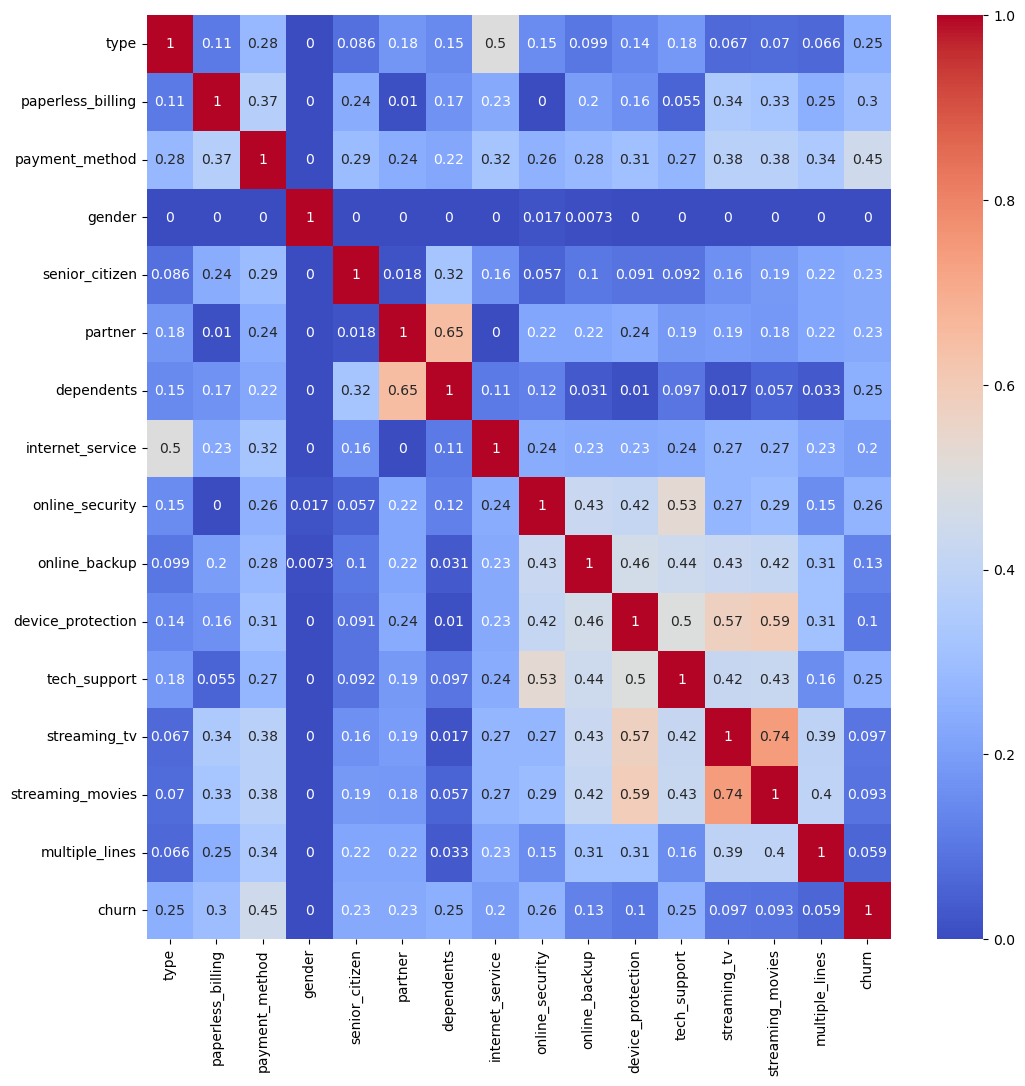

In [53]:
corr_matrix = phik_matrix(df[cat])


fig, ax = plt.subplots(figsize=(12, 12), dpi=100)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, ax=ax)
plt.show()

Есть высокие корреляции между столбцами 'streaming_movies' и 'streaming_tv'. 'streaming_movies' удалим.

### Проверим целевой столбец на дисбаланс классов

In [54]:
df['churn'].value_counts(normalize=True)

0   0.73
1   0.27
Name: churn, dtype: float64

Наблюдается дисбаланс классов в сторону класса "0" примерно в 3 раза

### Минивывод:

`Объединили столбцы методом "outer"`

`Отработали все пропущенные значения: там где пропуски вылезли в результате того, что клиент заключил контракт в тот день, когда была выкачана информация, были удалены, те же пропуски, которые получились в результате того, что клиент не пользуется данной услугой были заменены на "No"`

`Создали новый столбец с количеством месяцев, которые клиент пробыл в компании.`

`Создали новый столбец с целевой функцией`

`Построили график, который показывает сколько времени человеку требовалось для принятия решения.` 

*И как выяснилось, что клиент чаще всего отлетает в начале контракта и чем дольше он остаётся в компании, тем меньше вероятность его ухода.*

`Построили график, который показывает длительность отношений клиента с компанией`

*Как показал график, первые 30 месяцев обычно самые решающие, потом клиент "привыкает" и остается в компании.*

`Убедились на дискрайбе, что контрактов на 1 и 2 года подавляющее меньшенство`

`Построили график с ежемесячными платежами`

*График показал, что ежемесячный платеж больше у тех, кто ушёл. Это подтверждает и альтернативная гипотеза*

`Построили график общих платежей`

*По этому графику платили больше люди, которые давно в компании, но это и логично, ведь они там в среднем находятся дольше.*

`Построили графики для вычисления корреляций между столбцами`

**Исследовав категориальные столбцы следует отметить, что отток больше всего замечен:**
- в методе оплаты "электронный чек" (не автоматический тип оплаты)
- в типе оплаты "каждый месяц"
- в столбце в безбумажным выставлением счетов
- незначительно отток больше у людей непенсионного возраста и без партнёра 
- в категории людей без наличия иждивенцев
- у интернет провайдера "Fiber optic"
- в категории без наличия онлайн защиты
- в категории без онлайн резервного копирования
- в категории без защиты устройства
- в категории без технической поддержки

*Были обнаружены высокие корреляции и было решено удалить столбцы 'streaming_movies' и '"total_charges"'*

`В целевом столбце был обнаружен дисбаланс классов`

## Построение модели

**Разобьём датасет на фичи и таргеты**

In [55]:
X = df.drop(['churn', 'customer_id', 'begin_date', 'end_date', 'streaming_movies', 'total_charges'], axis=1)
y = df['churn']

Удалили:
- целевой признак
- неинформативный клиентский айди
- даты начала и конца отношений
- столбцы с мультиколлинеарностью

In [56]:
# создадим списки для объекто-категориальных и числовых значений
cat, numeric = [], []
[cat.append(col) if X[col].dtypes == 'category' else numeric.append(col) for col in X.columns];

**Разделим фичи и таргеты на тренировочные и тестовые в пропорции 3 к 1**

In [57]:
X, X_test, y, y_test = train_test_split(
                                    X, y, test_size=0.25, random_state=random_state, stratify=y
)

In [58]:
# проверка кол-ва строк и столбцов
X.shape, X_test.shape, y.shape, y_test.shape

((5274, 16), (1758, 16), (5274,), (1758,))

### Выпишем используемые в будущем кодировщики

In [59]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
ss = StandardScaler()

### Создадим словари перебираемых параметров будущих моделей и ансамблей

In [60]:
tree_params = {
    'decisiontreeclassifier__max_depth': range(1, 15)
}

forest_params = {
    'randomforestclassifier__n_estimators' : range(100, 400, 50), 
    'randomforestclassifier__max_depth' : range(5, 15, 3),
    'randomforestclassifier__min_samples_split' : (2, 3, 4),
    'randomforestclassifier__min_samples_leaf' : (1, 2, 3, 4)
}

regressor_params = {
    'logisticregression__C' : range(1, 6)
}

lgbm_params = {
    'boosting_type': ['gbdt', 'dart', 'goss'], 
    'importance_type': ['split', 'gain'], 
    'learning_rate': [0.1, 0.05, 0.3, 0.01, 0.6], 
    'max_depth': [-1, 3, 5, 6], 
    'n_estimators': [50, 100, 150, 500, 1000], 
    'n_jobs': [-1], 
    'subsample_for_bin': [200000, 50000, 100000]
}

xgboost_params = {
    'gradientboostingclassifier__max_depth' : range(10, 16 , 5), 
    'gradientboostingclassifier__learning_rate' : [0.1, 0,3, 0.01],
    'gradientboostingclassifier__n_estimators' : range(100, 400, 50)
}

cbr_params ={
             'iterations': [500], 
             'depth': [3, 5, 7, 10], 
             'learning_rate': [.1, .01, .5], 
             'l2_leaf_reg': [1, 3, 5, 10], 
             'loss_function': ['Logloss', 'CrossEntropy']
} 

### Напишем функцию рандомсерча

In [61]:
def randomiz_search(model, params: 'dict', num_iter: 'int', cv: 'int'):
    
    """Функция обучит модель с помощью RandomizedSearchCV
    и вернёт модель, обученную на лучших гиперпараметрах
    с самой высокой метрикой ROC_auc, а так же напечатает
    значение метрики ROC_auc и F1"""
        
    model = RandomizedSearchCV(
        model,
        param_distributions = params,
        n_iter = num_iter,
        verbose = 200,
        scoring = ['roc_auc','f1'],
        cv = cv,
        n_jobs = -1, 
        refit = 'roc_auc',random_state = random_state
    )
    model.fit(X, y)
    
#     выведем метрику ROC_auc на экран
    print("ROC_auc:", round(model.best_score_, 4))
#     выведем метрику F1 на экран
    print("F1:", round(model.cv_results_['mean_test_f1'].mean(), 4))
    
    return model

### Начнем строить препроцессинг для пайплайна

In [62]:
col_transformer_ohe = make_column_transformer(
    (ohe, cat),
    (ss, numeric),
    remainder='passthrough'
)

col_transformer_enc = make_column_transformer(
    (enc, cat),
    (ss, numeric),
    remainder='passthrough'
)

### Пайплайн для линейной регрессии, случайного леса, дерева решений и XGBoost

In [63]:
# линейная регрессия
pipeline_linear = make_pipeline(
    col_transformer_ohe, LogisticRegression(random_state=random_state, class_weight='balanced')
)

# случайный лес
pipeline_forest = make_pipeline(
    col_transformer_enc, RandomForestClassifier(random_state=random_state, class_weight='balanced')
)

# дерево решений
pipeline_tree = make_pipeline(
    col_transformer_enc, DecisionTreeClassifier(random_state=random_state, class_weight='balanced')
)

# XGBoost  
pipeline_xgboost = make_pipeline(
    col_transformer_enc, GradientBoostingClassifier(random_state=random_state)#, class_weight={0: 1, 1: 3})
)

In [64]:
# Список результатов ROC_auc
roc_auc = []

### Пайплайн для решающего дерева с рандомсерчем¶

In [65]:
tree = randomiz_search(pipeline_tree, tree_params, 20, 5)

# добавим лучший результат модели в список
roc_auc.append(round(tree.best_score_, 4))

Fitting 5 folds for each of 14 candidates, totalling 70 fits
ROC_auc: 0.8441
F1: 0.603


### Пайплайн для логистической регрессии с рандомсерчем

In [66]:
regression = randomiz_search(pipeline_linear, regressor_params, 10, 5)

# добавим лучший результат модели в список
roc_auc.append(round(regression.best_score_, 4))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
ROC_auc: 0.8385
F1: 0.6229


### Пайплайн для случайного леса с рандомсерчем

In [67]:
forest = randomiz_search(pipeline_forest, forest_params, 20, 5)

# добавим лучший результат модели в список
roc_auc.append(round(forest.best_score_, 4))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
ROC_auc: 0.8592
F1: 0.6354


### LGBMClassifier

In [68]:
model_lgbm = randomiz_search(
    LGBMClassifier(
                class_weight = 'balanced',
                random_state = random_state
                 ), 
    lgbm_params, 15, 8
    )

# добавим лучший результат модели в список
roc_auc.append(round(model_lgbm.best_score_, 4))

Fitting 8 folds for each of 15 candidates, totalling 120 fits
ROC_auc: 0.9071
F1: 0.6726


### XGBoost

In [69]:
model_xgboost = randomiz_search(pipeline_xgboost, xgboost_params, 10, 5)

# добавим лучший результат модели в список
roc_auc.append(round(model_xgboost.best_score_, 4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
ROC_auc: 0.8938
F1: 0.4427


### CatBoostClassifier

In [70]:
model_cbc = randomiz_search(
    CatBoostClassifier(
        auto_class_weights='Balanced',
        cat_features=cat, 
        eval_metric='AUC',
        random_seed = random_state
            ), 
    cbr_params, 15, 8
)

# добавим лучший результат модели в список
roc_auc.append(round(model_cbc.best_score_, 4))

Fitting 8 folds for each of 15 candidates, totalling 120 fits
0:	total: 187ms	remaining: 1m 33s
1:	total: 221ms	remaining: 55s
2:	total: 246ms	remaining: 40.8s
3:	total: 273ms	remaining: 33.9s
4:	total: 299ms	remaining: 29.6s
5:	total: 326ms	remaining: 26.8s
6:	total: 358ms	remaining: 25.2s
7:	total: 382ms	remaining: 23.5s
8:	total: 417ms	remaining: 22.7s
9:	total: 445ms	remaining: 21.8s
10:	total: 469ms	remaining: 20.9s
11:	total: 493ms	remaining: 20s
12:	total: 516ms	remaining: 19.3s
13:	total: 540ms	remaining: 18.7s
14:	total: 565ms	remaining: 18.3s
15:	total: 587ms	remaining: 17.7s
16:	total: 611ms	remaining: 17.4s
17:	total: 636ms	remaining: 17s
18:	total: 663ms	remaining: 16.8s
19:	total: 689ms	remaining: 16.5s
20:	total: 714ms	remaining: 16.3s
21:	total: 737ms	remaining: 16s
22:	total: 761ms	remaining: 15.8s
23:	total: 782ms	remaining: 15.5s
24:	total: 807ms	remaining: 15.3s
25:	total: 835ms	remaining: 15.2s
26:	total: 870ms	remaining: 15.2s
27:	total: 895ms	remaining: 15.1s
28:

### Проверим нашу метрику ROC_auc на устойчивость к дисбалансу классов

Для этого пропустим наши модели без настройки class_weight = 'balanced'

**Препроцессинги без баланса**

In [71]:
# линейная регрессия
pipeline_linear = make_pipeline(col_transformer_ohe, LogisticRegression(random_state=random_state))

# случайный лес
pipeline_forest = make_pipeline(col_transformer_enc, RandomForestClassifier(random_state=random_state))

# дерево решений
pipeline_tree = make_pipeline(col_transformer_enc, DecisionTreeClassifier(random_state=random_state))

# XGBoost  
pipeline_xgboost = make_pipeline(col_transformer_enc, GradientBoostingClassifier(random_state=random_state))

In [72]:
# Создадим пустой список, куда будем добавлять результаты метрик
roc_auc_unbalans = []

**Пройдемся по всем моделям с добавлением их результатов в наш новый список**

In [73]:
# дерево решений без баланса
tree_no_balans = randomiz_search(pipeline_tree, tree_params, 20, 5)

# добавим лучший результат модели в список
roc_auc_unbalans.append(round(tree_no_balans.best_score_, 4))

# логистическая регрессия без баланса
regression_no_balans = randomiz_search(pipeline_linear, regressor_params, 20, 5)

# добавим лучший результат модели в список
roc_auc_unbalans.append(round(regression_no_balans.best_score_, 4))

# случайный лес без баланса
forest_no_balans = randomiz_search(pipeline_forest, forest_params, 20, 5)

# добавим лучший результат модели в список
roc_auc_unbalans.append(round(forest_no_balans.best_score_, 4))

# lgbmlassifier без баланса
model_lgbm_no_balans = randomiz_search(LGBMClassifier(random_state=random_state), lgbm_params, 15, 8)

# добавим лучший результат модели в список
roc_auc_unbalans.append(round(model_lgbm_no_balans.best_score_, 4))

# xgboost без баланса
model_xgboost_no_balans = randomiz_search(pipeline_xgboost, xgboost_params, 10, 5)

# добавим лучший результат модели в список
roc_auc_unbalans.append(round(model_xgboost_no_balans.best_score_, 4))

# катбуст без баланса
model_cbc_no_balans = randomiz_search(
    CatBoostClassifier(cat_features=cat, eval_metric='AUC', random_seed=random_state), 
                    cbr_params, 15, 8 
                    )

# добавим лучший результат модели в список
roc_auc_unbalans.append(round(model_cbc_no_balans.best_score_, 4))

Fitting 5 folds for each of 14 candidates, totalling 70 fits
ROC_auc: 0.8443
F1: 0.5025
Fitting 5 folds for each of 5 candidates, totalling 25 fits
ROC_auc: 0.8388
F1: 0.5759
Fitting 5 folds for each of 20 candidates, totalling 100 fits
ROC_auc: 0.8604
F1: 0.588
Fitting 8 folds for each of 15 candidates, totalling 120 fits
ROC_auc: 0.908
F1: 0.6303
Fitting 5 folds for each of 10 candidates, totalling 50 fits
ROC_auc: 0.8938
F1: 0.4427
Fitting 8 folds for each of 15 candidates, totalling 120 fits
0:	total: 23.5ms	remaining: 11.7s
1:	total: 46.5ms	remaining: 11.6s
2:	total: 67.5ms	remaining: 11.2s
3:	total: 89.2ms	remaining: 11.1s
4:	total: 110ms	remaining: 10.9s
5:	total: 132ms	remaining: 10.9s
6:	total: 154ms	remaining: 10.8s
7:	total: 175ms	remaining: 10.7s
8:	total: 189ms	remaining: 10.3s
9:	total: 210ms	remaining: 10.3s
10:	total: 230ms	remaining: 10.2s
11:	total: 254ms	remaining: 10.3s
12:	total: 289ms	remaining: 10.8s
13:	total: 313ms	remaining: 10.9s
14:	total: 333ms	remaining: 1

### Результаты обучения моделей

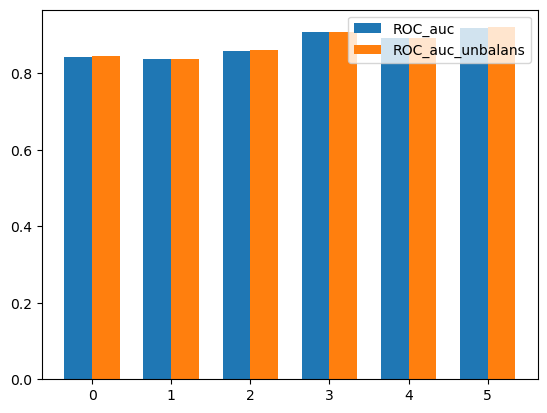

In [74]:
bar_width = 0.35
x_axis = range(len(roc_auc))

plt.bar(x_axis, roc_auc, width=bar_width, label='ROC_auc')
plt.bar([i + bar_width for i in x_axis], roc_auc_unbalans, width=bar_width, label='ROC_auc_unbalans')
plt.xticks([i + bar_width / 2 for i in x_axis], x_axis)
plt.legend()
plt.show()

P.S. XGBoost оба раза считали без баланса классов

In [75]:
roc_auc, roc_auc_unbalans

([0.8441, 0.8385, 0.8592, 0.9071, 0.8938, 0.9185],
 [0.8443, 0.8388, 0.8604, 0.908, 0.8938, 0.9207])

Таким образом, эмпирическим путём мы подтвердили, что ROC_auc не чувствительна к балансу классов

In [76]:
# model_cbc_no_balans.best_params_

## Предсказания

### Посчитаем AUC-ROC на тестовой выборке лучшей моделью

In [77]:
# Получаем вероятности принадлежности к классу 1 на тестовом наборе данных
y_pred_proba = model_cbc_no_balans.predict_proba(X_test)[:, 1]

# Вычисляем метрику roc_auc
roc_auc = roc_auc_score(y_test, y_pred_proba)
print('Оценка ROC-AUC:', round(roc_auc, 4))
print('Оценка F1:', round(f1_score(y_test, model_cbc_no_balans.predict(X_test)), 4))

Оценка AUC-ROC: 0.9274
Оценка F1: 0.7476


### Проверика модели на адекватность

In [78]:
dummy_model = DummyClassifier(strategy='most_frequent',  random_state=random_state)
dummy_model.fit(X, y)
prediction = dummy_model.predict(X_test)
print(roc_auc_score(y_test, prediction))

0.5


Модель адекватна

### Построим график важности признаков

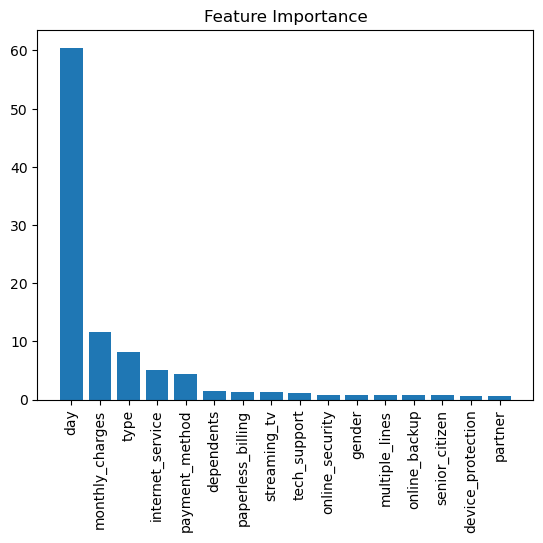

In [79]:
# Получаем лучшую модель и ее параметры
best_model = model_cbc.best_estimator_
best_params = model_cbc.best_params_

# Получаем важность признаков
importance = best_model.feature_importances_

# Сортируем признаки по убыванию важности
sorted_idx = importance.argsort()[::-1]

# Строим график важности признаков
plt.bar(range(X.shape[1]), importance[sorted_idx])
plt.xticks(range(X.shape[1]), X.columns[sorted_idx], rotation=90)
plt.title("Feature Importance")
plt.show()

Как видим по графику самый важный признак с большим отрывом у нас решает время проведенное в компании. Следующий по важности признак - ежемесячный платеж, а затем тип оплаты.

### Построим матрицу ошибок

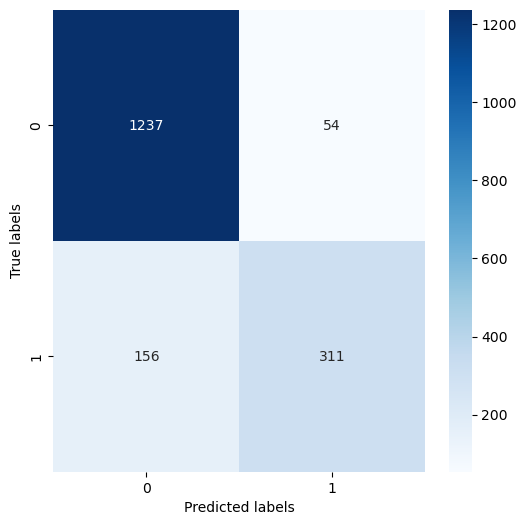

In [80]:
# Строим матрицу ошибок
cm = confusion_matrix(y_test, model_cbc_no_balans.predict(X_test))

# Строим график матрицы ошибок
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

Левый верхний квадрат: наши верные предсказания, что человек не ушёл
Правый верхний квадрат: ошибка первого рода, модель предсказала, что человек останется, а он ушёл
Левый нижний квадрат: ошибка второго рода, модель предсказала, что человек уйдет, а он остается
Правый нижний квадрат: наши верные предсказания, что человек ушёл

Как видим из матрицы, ошибок 1 рода у нас немного, а вот ошибок 2 рода немного больше.

### Построим график ROC-AUC

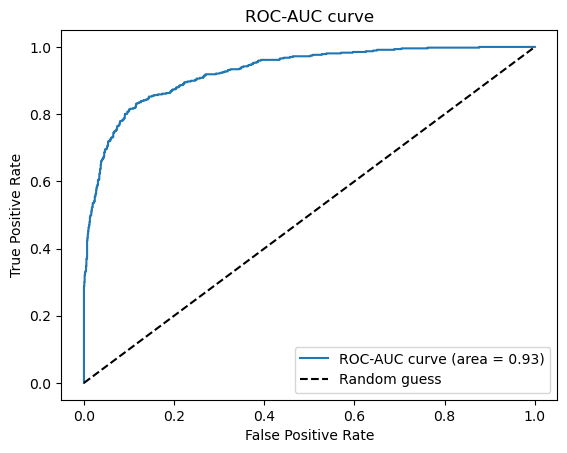

In [81]:
# Считаем значения FPR и TPR для разных пороговых значений
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Строим ROC-AUC кривую
plt.plot(fpr, tpr, label='ROC-AUC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve')
plt.legend(loc='lower right')
plt.show()

Судя по площади кривой, можем считать нашу модель очень точной. Изменение порога не требуется

### Вывод

1. Разбили датасет на фичи и таргет.
2. Удалили:

- целевой признак
- неинформативный клиентский айди
- даты начала и конца отношений
- столбцы с мультиколлинеарностью

3. Разделили фичи и таргет на обучающие и тестовые выборки 3/1
4. Создали словари перебираемых гиперпараметров
5. Написали пайплайн для каждой модели (для регрессии использовали Ohe по категориальным столбцам,
для других моделей использовали Ordinal, для числовых использовали StandardScaler)
6. Запустили в работу каждую модель. Лучшую метрику добавляли в список и выводили на экран
7. Проверили метрику ROC_auc на устойчивость к дисбалансу классов (устойчива)

**Лучшей моделью показал себя катбуст CatBoostClassifier без баланса классов (это видно на графике и просто из табличныхх значений). На нём и будем предсказывать на тестовой выборке.**

8. Оценка AUC-ROC на тестовой модели: 0.9274. F1 на тестовой модели: 0.7476.
9. Лучшие гиперпараметры:
```
{'loss_function': 'Logloss',
 'learning_rate': 0.1,
 'l2_leaf_reg': 1,
 'iterations': 500,
 'depth': 5}
```
10. Проверили модель на адекватность.
11. Построили график важности признаков:

- самый важный - время проведенное в компании
- следующий по важности признак - ежемесячный платеж
- замыкает тройку тип оплаты 

12. Из матрицы ошибок мы увидели достаточно низкое кол-во ошибок первого рода и чуть больше ошибок второго рода. 
13. Построили график кривой ROC-AUC и оценили ее площадь. Модель можем считать очень точной. Изменение порога не требуется.

## Отчёт по вопросам

**1. Какие пункты плана были выполнены, а какие — нет. Почему?**
- Все пункты были выполнены согласно изначальному [плану работы](#План-работы)

**2. Какие трудности возникли и как вы их преодолели?**

- Не могу сказать, что было сложно, но в этот раз пришлось много раз прогонять работу в погоне за лучшей метрикой. Изначально метрика была относительно плохой, хотя и переходила порог требования. Причина оказалась в новом столбце, в котором я обозначил кол-во месяцев, проведенных клиентом в компании. Но я и подумать не мог, что при переводе месяцев в дни метрика может так сильно подскочить, хотя данные по сути никак не менялись (при шкалировании то они должны быть одинаковыми).

**3. Какие ключевые шаги в решении задачи вы выделили?**
- **Определил, какие факторы способствуют уходу клиента и на их основании создал модель прогнозирования оттока клиентов.
Факторы, влияющие на уход:**

    1. время проведённое в компании. Через 30 месяцев клиент полностью привыкает к компании и риск его ухода крайне низок
    2. высокая ежемесячная плата относительно тех, кто остается
    3. тип оплаты "каждый месяц"
    4. метод оплаты "электронный чек" (не автоматический тип оплаты)
    5. у интернет провайдера "Fiber optic"
    6. безбумажное выставление счетов
    7. незначительно больше у людей непенсионного возраста и без партнёра
    8. в категории людей без наличия иждивенцев
    9. в категории без наличия онлайн защиты
    10. в категории без онлайн резервного копирования
    11. в категории без защиты устройства
    12. в категории без технической поддержки

Это всё можно увидеть в результатах исследовательского анализа по [категориальным столбцам](#Построим-графики-распределения-категориальных-столбцов)

Перед разбиением на обучающие признаки провели [поиск](#Посмотрим-на-корреляции-между-признаками) столбцов с высокими корреляциями и было решено удалить столбцы 'streaming_movies' и 'total_charges'. Так же на всякий случай был проверен результат метрики без удаления этих столбцов, и он оказался хуже.

В целевом столбце был обнаружен дисбаланс классов

**4. Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?**  

**Признаки, участвующие в обучении:**

Самым важным признаком является в нашем случае новый полученный признак "кол-во дней". При чем этот признак на графике более чем в 5 раз важнее ближайшей к нему фичи. Дальше у нас идут:
- ежемесячная оплата. Мы приняли гипотезу о том, что плата в месяц  для людей ушедших и оставшихся в компании различна. График показал, что ушедшие клиенты платили больше.
- тип оплаты. Люди, у которых тариф оплаты раз в месяц уходят в 6-7 раз чаще чем те, у кого тариф оплаты раз в год или раз в два года.
- интернет провайдер. У провайдера Fiber Optik отток людей примерно в 3 раза больше чем у остальных.
- метод оплаты. В методе оплаты "электронный чек" (не автоматический тип оплаты) клиенты уходят в 3-4 раза чаще относительно остальных.

Остальные фичи не несут важности относительно первых столбцов и являются третьестепенными. Ознакомиться с ними более подробно можно [здесь](#Построим-график-важности-признаков)

Все фичи прошли предобработку:
- во-первых, были удалены дубликаты и пропущенные значения
- в строки с клиентами и услугами, которыми они не пользуются были проставлены значения 'No'
- самый важный столбец с кол-вом дней был создан при помощи столбцов "начала обслуживания" и "конец обслуживания". К тем, кто не ушёл из компании была доставлена дата конца обслуживания в день выгрузки базы.
- сгенерировали целевой столбец 
- разделив выборку на трейн и тест (3/1), мы положили трейн в пайплайн, где прошкалировали числовые фичи методом StandartScaller. Категориальные столбцы были закодированы при помощи Ordinal для всех моделей, кроме линейной регрессии. Для нее кодировали с помощью OneHot.
- удалили из обучающей выборки:
`целевой признак`,
`неинформативный клиентский айди`,
`даты начала и конца отношений`,
`столбцы с мультиколлинеарностью`

**5. Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?**

Обучение проходило на моделях: дерево решений, логистическая регрессия, случайный лес, LGBMClassifier, XGBoost и кэтбуст (в том же порядке).
Все модели прошли обучения по два раза: на сбалансированных классах и на изначальном дисбалансе. Лучшей моделью показал себя катбуст на несбалансированной выборке. Результаты обучения моделей можно посмотреть на [графике](#Результаты-обучения-моделей). 
Соответственно кэтбустом и прогоняли тестовую модель.

*Оценка ROC-AUC на тестовой модели: 0.9274. F1 на тестовой модели: 0.7476.*

*Лучшие гиперпараметры:*
```
{'loss_function': 'Logloss',
 'learning_rate': 0.1,
 'l2_leaf_reg': 1,
 'iterations': 500,
 'depth': 5}
```

**Так как целью у нас было достижение качества модели ROC-AUC не меньше 0.85, то с нашим результатом мы можем говорить о высоком качестве модели. Это подтверждает [матрица ошибок](#Построим-матрицу-ошибок) и [график ROC-AUC](#Построим-график-ROC-AUC). Ошибок первого и второго рода у нас немного, а площадь аук-кривой говорит так же о высокой точности и о том, что изменение порога не требуется. Цель была достигнута.**

**Рекомендации:** обратить внимание на клиентов с тарифами ежемесячным тарифом оплаты, особенно на тех, кто платит по более высокому тарифу. Так же в зоне риска находятся клиенты у провайдера Fiber Optik или с методом оплаты "электронный чек" (не автоматический тип оплаты). Если вовремя "подогреть" таких клиентов приятными условиями и удержать на 30 месяцев, то риск их ухода сводится к минимуму